In [1]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from utils import  data_preprocessing
 
def data_preparation(num_feature, rho, num_row):
    c = 0.3
    u1 = np.random.randn(num_feature)
    u1 = (u1 - np.mean(u1)) / (np.std(u1) * np.sqrt(num_feature))
    u2 = np.random.randn(num_feature)
    u2 -= u2.dot(u1) * u1
    u2 /= np.linalg.norm(u2)

    # k = np.random.randn(num_feature)
    # u1 = np.random.randn(num_feature) 
    # u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
    # u1 /= np.linalg.norm(u1)
    # k /= np.linalg.norm(k)
    # u2 = k
    w1 = c * u1
    w2 = c * (rho * u1 + np.sqrt((1 - rho**2))*u2)
    X = np.random.normal(0, 1, (num_row, num_feature))
    eps1 = np.random.normal(0, 0.01)
    eps2 = np.random.normal(0, 0.01)
    Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
    Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
    X, target_df1, target_df2 = data_preprocessing(input_data=X, target_label1=Y1, target_label2=Y2)
    Y = np.concatenate((target_df1, target_df2), axis=1)
    return X, Y


In [2]:
X, Y = data_preparation(num_feature=5, rho=0.3, num_row=1000)

In [4]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Instantiatethe XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123, n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

print("y1 RMSE:%.4f" % np.sqrt(mean_squared_error(y_test[:,0], preds[:,0])))
print("y2 RMSE:%.4f" % np.sqrt(mean_squared_error(y_test[:,1], preds[:,1])))

RMSE: 0.028007
y1 RMSE:0.0260
y2 RMSE:0.0299


In [5]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print("y1 RMSE:%.4f" % np.sqrt(mean_squared_error(y_test[:,0], preds[:,0])))
print("y2 RMSE:%.4f" % np.sqrt(mean_squared_error(y_test[:,1], preds[:,1])))

RMSE: 0.127017
y1 RMSE:0.1217
y2 RMSE:0.1321


In [6]:
dmatrix = xgb.DMatrix(data=X, label=Y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=4,
                    num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-rmse-mean']).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.121974        0.000579        0.123404       0.002280
1         0.092079        0.000404        0.094841       0.001850
2         0.070704        0.000351        0.074634       0.001531
3         0.055134        0.000372        0.060338       0.001570
4         0.043980        0.000300        0.050226       0.001366
4    0.050226
Name: test-rmse-mean, dtype: float64


In [7]:
dmatrix = xgb.DMatrix(data=X, label=Y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=4,
                    num_boost_round=5, metrics='mae', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-mae-mean']).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.097289       0.000665       0.098175      0.002450
1        0.072559       0.000627       0.074407      0.002004
2        0.055085       0.000446       0.057764      0.001687
3        0.042420       0.000279       0.046000      0.001457
4        0.033237       0.000335       0.037637      0.001042
4    0.037637
Name: test-mae-mean, dtype: float64


In [9]:
import pandas as pd
dmatrix = xgb.DMatrix(data=X, label=Y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror", "max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:
    # Update l2 strength
    params['lambda'] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2,
                            num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse['test-rmse-mean'].tail(1).values[0])
    
# Loot at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2      rmse
0    1  0.060424
1   10  0.067673
2  100  0.097445


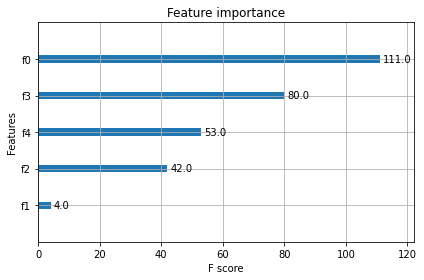

In [10]:
dmatrix = xgb.DMatrix(data=X, label=Y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain=dmatrix, params=params, num_boost_round=10)

# Plot the feature importance
xgb.plot_importance(xg_reg);
plt.tight_layout()

In [11]:
import numpy as num
from sklearn.model_selection import cross_val_score
xgboo_reg = xgb.XGBRegressor()

ourScores = cross_val_score(xgboo_reg, X_train, y_train , scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 10)
#cross_val_score has a `neg_root_mean_squared_error` can be turned into a positive value by multiplying it by -1
print(num.mean(ourScores), num.std(ourScores))
print(ourScores) # output: score of our model

-0.021342667944247645 0.0022638649686283273
[-0.02071105 -0.01969938 -0.01993125 -0.02121442 -0.02090855 -0.0215668
 -0.02582508 -0.02414945 -0.02222085 -0.01719984]


In [14]:
def return_score(param):
    ourNewModel = xgb.XGBRegressor(**param)
  # A value that has been cross-validated for -(neg_root_mean_squared_error) is returned when parameters are used as a keyword argument by return_score() method.
    rootMeanSquareError = num.mean(cross_val_score(ourNewModel, X_train[:1000],y_train[:1000], cv = 4, n_jobs =-1, scoring='neg_root_mean_squared_error')) # training 1000 samples in both first part 'X_train' an second part 'y_train'
    return rootMeanSquareError

In [15]:
import optuna
from optuna import Trial, visualization # visualizations that plot the optimization results
from optuna.samplers import TPESampler # Samplers class that defines the hyper-parameter space

In [18]:
def objective(trial):
    parameter = {
      "n_estimators" : trial.suggest_int('estimators', 0, 500), # show integer parameters between 0 and 500 for estimators
      'max_depth':trial.suggest_int('depth', 3, 5), # show integer parameters between 3 and 5 for depth
      'reg_alpha':trial.suggest_uniform('alpha',0,6), # set a uniformly distributed numbers between 0 and 6 for alpha
      'reg_lambda':trial.suggest_uniform('lambda',0,2), # set a uniformly distributed numbers between 0 and 2 for lambda
      'min_child_weight':trial.suggest_int('childweight',0,5), # show integer parameters between 0 and 5 for childweight
      'gamma':trial.suggest_uniform('ourgamma', 0, 4), # set a uniformly distributed numbers between 0 and 4 for gamma
      'learning_rate':trial.suggest_loguniform('ourlearning_rate',0.05,0.5), # set a log distribution between 0.05 and 0.5 for learning rate
      'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9), # set a uniformly distributed numbers between 0.4 and 0.9 for colsample_bytree
      'subsample':trial.suggest_uniform('sample',0.4,0.9),
      'nthread' : -1
    }
  #returns the regressionModelse score
    return(return_score(parameter))

In [19]:
studyObject1 = optuna.create_study(
    direction='minimize', sampler=TPESampler()) # Bayesian Sampling Technique
studyObject1.optimize(objective, n_trials= 100)

[I 2023-01-07 00:56:54,381] A new study created in memory with name: no-name-aebe582d-b2a5-4f84-a9c9-088050b66d9d
[I 2023-01-07 00:56:55,001] Trial 0 finished with value: -0.10112562793001874 and parameters: {'estimators': 283, 'depth': 5, 'alpha': 4.050725738312592, 'lambda': 1.2732348335472174, 'childweight': 3, 'ourgamma': 0.3033992792570661, 'ourlearning_rate': 0.39018539363813354, 'colsample_bytree': 0.8471007724816808, 'sample': 0.44265872681478186}. Best is trial 0 with value: -0.10112562793001874.
[I 2023-01-07 00:56:55,241] Trial 1 finished with value: -0.09964130568041424 and parameters: {'estimators': 292, 'depth': 3, 'alpha': 3.250589223978798, 'lambda': 1.2742275825853553, 'childweight': 4, 'ourgamma': 0.8439325199598637, 'ourlearning_rate': 0.14746121910274396, 'colsample_bytree': 0.4476423967193198, 'sample': 0.8099530722660511}. Best is trial 0 with value: -0.10112562793001874.
[I 2023-01-07 00:56:55,420] Trial 2 finished with value: -0.09875378003469146 and parameters:

In [20]:
optuna.visualization.plot_slice(studyObject1)

In [21]:
studyObject1.best_params

{'estimators': 0,
 'depth': 3,
 'alpha': 4.719067643312643,
 'lambda': 1.6150605457278278,
 'childweight': 0,
 'ourgamma': 2.868833959925093,
 'ourlearning_rate': 0.10555651811524946,
 'colsample_bytree': 0.8025608696446037,
 'sample': 0.4579976808080147}

In [22]:
parameter = {}
print(f"without optimization {return_score(parameter)}")
print(f"with optimization {return_score(studyObject1.best_params)}")

without optimization -0.02306360792278799
[00:57:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "childweight", "depth", "estimators", "ourgamma", "ourlearning_rate", "sample" } are not used.

[00:57:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "childweight", "depth", "estimators", "ourgamma", "ourlearning_rate", "sample" } are not used.

[00:57:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "childweight", "depth", "estimators", "ourgamma", "ourlearning_rate", "sample" } are not used.

[00:57:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "childweight", "depth", "estimators", "ourgamma", "our